# DL_HW2

In [1]:
import numpy as np
import pandas as pd
import time, os, pickle, json, random

from imageio import imread, imwrite
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm, trange
import multiprocessing
from multiprocessing import Pool
from skimage import feature, data, color
import skimage
import cv2
from functools import partial
from sklearn import preprocessing
from sklearn.linear_model import Perceptron

from abc import ABCMeta, abstractmethod

cpus = multiprocessing.cpu_count()
print(cpus)
%autosave 120

160


Autosaving every 120 seconds


## Tool Box

In [2]:
# onehot
def self_onehot(x, c = 50) : 
    x_onehot = np.zeros([x.shape[0], c])
    for i in range(x.shape[0]) :
        x_onehot[i, int(x[i])] = 1
    return x_onehot

# 讀取圖片function
def read_img(path) :
    img = cv2.imread(path)
    img = cv2.resize(img, (256, 256))
    return img

# color histogram
def color_histogram(img, hist_size = 256):
    img = img.astype(np.uint8)
    color = ('b','g','r')
    histogram = []
    for idx, color in enumerate(color):
        h = cv2.calcHist(img,[idx],None,[hist_size],[0, 256])
        histogram.append(h)
    return np.array(histogram).squeeze().reshape(1, -1)
# histogram of gradient
def get_hog_feature(img) :
    img = img.astype(np.uint8)
    hog_vec, hog_vis = feature.hog(img, 
                               pixels_per_cell=(64, 64), 
                               cells_per_block = [1, 1],
                               channel_axis = 2, 
                               visualize=True)
    return hog_vec

# haralick
def get_haralick(img): 
    values_temp = []
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = skimage.feature.graycomatrix(img, [2, 8, 16], [0, np.pi / 4, np.pi / 2, np.pi * 3 / 4], 256, symmetric=True, normed=True)  # , np.pi / 4, np.pi / 2, np.pi * 3 / 4
    # print(glcm.shape) 
    for prop in {'contrast', 'dissimilarity','homogeneity', 'energy', 'correlation', 'ASM'}:
        temp = skimage.feature.graycoprops(glcm, prop)
        temp = np.array(temp).reshape(-1)
        values_temp.append(temp)
        # print(prop, temp)
        # print('len:',len(temp))
        # print('')
    values_temp = np.array(values_temp).reshape(1, -1)
    return (values_temp)

## Read Data and Feature Extraction

In [3]:
# 讀取index
os.chdir('/home/rita/111/111-2DL/HW1')
train_idx = pd.read_table('train.txt', header = None, sep = ' ')
val_idx = pd.read_table('val.txt', header = None, sep = ' ')
test_idx = pd.read_table('test.txt', header = None, delimiter = ' ')
train_idx = np.array(train_idx)
val_idx = np.array(val_idx)
test_idx = np.array(test_idx)
train_y = train_idx[::, 1].astype(float)
val_y = val_idx[::, 1].astype(float)
test_y = test_idx[::, 1].astype(float)
os.chdir('/home/rita/111/111-2DL/HW2')

In [4]:
# 讀取圖片
# 40 s
os.chdir('/home/rita/111/111-2DL/HW1')
s = time.time()
if __name__ == '__main__' : 
    with Pool(processes = 80) as p:
        train_pic = list(tqdm(p.imap(read_img, train_idx[::, 0], chunksize=100), total = train_idx.shape[0]))
        val_pic = list(tqdm(p.imap(read_img, val_idx[::, 0], chunksize=100), total = val_idx.shape[0]))
        test_pic = list(tqdm(p.imap(read_img, test_idx[::, 0], chunksize=100), total = test_idx.shape[0]))
os.chdir('/home/rita/111/111-2DL/HW2')

train_pic_list = train_pic
val_pic_list = val_pic
test_pic_list = test_pic

train_pic = np.array(train_pic)
val_pic = np.array(val_pic)
test_pic = np.array(test_pic)

np.save('./data/train_pic', train_pic)
np.save('./data/val_pic', val_pic)
np.save('./data/test_pic', test_pic)

func = partial(color_histogram, hist_size = 64)
with Pool(processes = 40) as p:
    train_x_color_hist = list(tqdm(p.imap(func, train_pic_list, chunksize=1000), total = train_idx.shape[0]))
    val_x_color_hist = list(tqdm(p.imap(func, val_pic_list, chunksize=100), total = val_idx.shape[0]))
    test_x_color_hist = list(tqdm(p.imap(func, test_pic_list, chunksize=100), total = test_idx.shape[0]))
train_x_color_hist = np.array(train_x_color_hist).squeeze()
val_x_color_hist = np.array(val_x_color_hist).squeeze()
test_x_color_hist = np.array(test_x_color_hist).squeeze()

with Pool(processes = 40) as p:
    train_x_hog = list(tqdm(p.imap(get_hog_feature, train_pic_list, chunksize=100), total = train_idx.shape[0]))
    val_x_hog = list(tqdm(p.imap(get_hog_feature, val_pic_list, chunksize=100), total = val_idx.shape[0]))
    test_x_hog = list(tqdm(p.imap(get_hog_feature, test_pic_list, chunksize=100), total = test_idx.shape[0])) 
train_x_hog = np.array(train_x_hog)
val_x_hog = np.array(val_x_hog)
test_x_hog = np.array(test_x_hog)

with Pool(40) as p:
    train_x_haralick = list(tqdm(p.imap(get_haralick, train_pic_list, chunksize=100), total = train_idx.shape[0]))
    val_x_haralick = list(tqdm(p.imap(get_haralick, val_pic_list, chunksize=100), total = val_idx.shape[0]))
    test_x_haralick = list(tqdm(p.imap(get_haralick, test_pic_list, chunksize=100), total = test_idx.shape[0])) 
train_x_haralick = np.array(train_x_haralick).squeeze()
val_x_haralick = np.array(val_x_haralick).squeeze()
test_x_haralick = np.array(test_x_haralick).squeeze()

train_x = np.concatenate([train_x_color_hist, train_x_hog, train_x_haralick], axis = 1)
val_x = np.concatenate([val_x_color_hist, val_x_hog, val_x_haralick], axis = 1)
test_x = np.concatenate([test_x_color_hist, test_x_hog, test_x_haralick], axis = 1)

np.save('./data/train_x', train_x)
np.save('./data/val_x', val_x)
np.save('./data/test_x', test_x)
print(time.time() - s)

100%|██████████| 450/450 [00:07<00:00, 58.64it/s]


359.1039261817932


In [5]:
# 讀取index
os.chdir('/home/rita/111/111-2DL/HW1')
train_idx = pd.read_table('train.txt', header = None, sep = ' ')
val_idx = pd.read_table('val.txt', header = None, sep = ' ')
test_idx = pd.read_table('test.txt', header = None, delimiter = ' ')
train_idx = np.array(train_idx)
val_idx = np.array(val_idx)
test_idx = np.array(test_idx)
train_y = train_idx[::, 1].astype(float)
val_y = val_idx[::, 1].astype(float)
test_y = test_idx[::, 1].astype(float)
os.chdir('/home/rita/111/111-2DL/HW2')

In [6]:
train_y_onehot = self_onehot(train_y)
val_y_onehot = self_onehot(val_y)
test_y_onehot = self_onehot(test_y)

In [7]:
train_pic = np.load('./data/train_pic.npy')
val_pic = np.load('./data/val_pic.npy')
test_pic = np.load('./data/test_pic.npy')
train_x = np.load('./data/train_x.npy')
val_x = np.load('./data/val_x.npy')
test_x = np.load('./data/test_x.npy')

# Computational Graph

In [ ]:
# Implement by computational graph
# class Node:
#     def __init__(self, inputs=[]):
#         self.inputs = inputs
#         self.outputs = []
#         for n in self.inputs:
#             n.outputs.append(self)
#         self.value = None
#         # self.gradients = {}

#     def forward(self):
#         raise NotImplemented

#     def backward(self):
#         raise NotImplemented

# class Input(Node):
#     def __init__(self, name=''):
#         Node.__init__(self, inputs=[])
#         self.name = name
#         # self.value = value

#     def forward(self, value=None):
#         if value is not None:
#             self.value = value

#     def backward(self):
#         # teacher's
#         # self.gradients = {self:0}
#         # for n in self.outputs:
#         #     grad_cost = n.gradients[self]
#         #     self.gradients[self] += grad_cost * 1

#         pass

# class Add(Node):
#     def __init__(self, x, y):
#         Node.__init__(self, inputs=[x, y])

#     def forward(self):
#         self.value = sum([n.value for n in self.inputs])

#     def backward(self):
#         # teacher's
#         # self.gradients = {n:0 for n in self.inputs}
#         # for n in self.outputs:  
#         #     grad_cost = n.gradients[self]
#         #     for i in range(len(self.inputs)):
#         #         self.gradients[self.inputs[i]] += grad_cost * 1

#         for n in self.inputs:
#             if n not in self.outputs:
#                 n.value += self.value

# class Multiply(Node):
#     def __init__(self, x, y):
#         Node.__init__(self, inputs=[x, y])

#     def forward(self):
#         self.value = np.dot(self.inputs[0].value, self.inputs[1].value)

#     def backward(self):
#         for n in self.inputs:
#             if n not in self.outputs:
#                 n.value += self.value * n.inputs[np.abs(self.inputs.index(n)-1)].value

# class Sigmoid(Node):
#     def __init__(self, x):
#         Node.__init__(self, inputs=[x])

#     def sigmoid(self, x):
#         return 1 / (1 + np.exp(-x))

#     def forward(self):
#         self.value = self.sigmoid(self.inputs[0].value)

#     def backward(self):
#         for n in self.inputs:
#             if n not in self.outputs:
#                 n.value += self.value * (1 - self.value) * self.outputs[0].value

# class TwoLayerPerceptron:
#     def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate=0.1):
#         self.n_inputs = n_inputs
#         self.n_hidden = n_hidden
#         self.n_outputs = n_outputs
#         self.learning_rate = learning_rate
#         # Initialize weights and biases with random values
#         self.W1 = np.random.randn(n_inputs, n_hidden)
#         self.b1 = np.random.randn(n_hidden)
#         self.W2 = np.random.randn(n_hidden, n_outputs)
#         self.b2 = np.random.randn(n_outputs)

#         # Create input and output nodes
#         self.inputs = [Input(name='input') for i in range(n_inputs)]
#         self.hidden_inputs = [Input(name=f'hidden_input_{i}') for i in range(n_hidden)]
#         self.outputs = [Input(name='output') for i in range(n_outputs)]

#         # Create nodes for each operation in the forward pass
#         self.weights1_node = []
#         for i in range(n_inputs):
#             t = Input(name = 'w1')
#             t.forward(value = self.W1)
#             temp = Multiply(self.inputs[i], t)
#             self.weights1_node.append(temp)
#         print(len(self.output_node))
#         self.bias1_node = []
#         for i in range(n_inputs):
#             t = Input(name = 'b1')
#             t.forward(value = self.b1)
#             temp = Add(self.weights1_node[i], t)
#             self.bias1_node.append(temp)
        
#         self.hidden_activations_node = []
#         for i in range(n_inputs):
#             temp = Sigmoid(self.bias1_node[i])
#             self.hidden_activations_node.append(temp)

#         self.weights2_node = []
#         for i in range(n_inputs):
#             t = Input(name = 'w2')
#             t.forward(value = self.W2)
#             temp = Multiply(self.hidden_activations_node[i], t)
#             self.weights2_node.append(temp)

#         self.bias2_node = []
#         for i in range(n_inputs):
#             t = Input(name = 'b2')
#             t.forward(value = self.b2)
#             temp = Add(self.weights2_node[i], t)
#             self.bias2_node.append(temp)

#         self.output_node = []
#         for i in range(n_inputs):
#             temp = Sigmoid(self.bias2_node[i])
#             self.hidden_activations_node.append(temp)
        
#         print(len(self.output_node))


#         # self.weights1_node = Multiply(self.inputs[0], Input(value=self.W1))
#         # self.bias1_node = Add(self.weights1_node, Input(value=self.b1))
#         # self.hidden_activations_node = Sigmoid(self.bias1_node)
#         # self.weights2_node = Multiply(self.hidden_activations_node, Input(value=self.W2))
#         # self.bias2_node = Add(self.weights2_node, Input(value=self.b2))
#         # self.output_node = Sigmoid(self.bias2_node)

#     def forward(self, X):
#         # Set input values
#         for i in range(self.n_inputs):
#             self.inputs[i].forward(X[:,i])
#         # Compute activations of hidden layer
#         self.weights1_node.forward()
#         self.bias1_node.forward()
#         self.hidden_activations_node.forward()
#         # Compute activations of output layer
#         self.weights2_node.forward()
#         self.bias2_node.forward()
#         self.output_node.forward()
#         # Return output node value
#         return self.output_node.value
    
#     def backward(self, y):
#         # Compute error at output layer
#         output_error_node = Add(self.outputs[0], Input(value=-y))
#         output_delta_node = Multiply(output_error_node, Sigmoid(self.outputs[0], deriv=True))
#         # Compute error at hidden layer
#         hidden_error_node = Multiply(output_delta_node, Input(value=self.W2.T))
#         hidden_delta_node = Multiply(hidden_error_node, Sigmoid(self.hidden_activations_node, deriv=True))
#         # Update weights and biases
#         dW2_node = Multiply(self.hidden_activations_node, output_delta_node)
#         self.W2 -= self.learning_rate * dW2_node.inputs[1].value
#         db2_node = output_delta_node
#         self.b2 -= self.learning_rate * db2_node.value
#         dW1_node = Multiply(self.inputs[0], hidden_delta_node)
#         self.W1 -= self.learning_rate * dW1_node.inputs[1].value
#         db1_node = hidden_delta_node
#         self.b1 -= self.learning_rate * db1_node.value
#         # Backward pass
#         dhidden_node = Add(self.weights1_node, db1_node)
#         dinput_node = Multiply(self.inputs[0], dhidden_node)
#         # Return gradients
#         return dinput_node.value
    
#     def train(self, X, y, n_epochs=1000):
#         for i in range(n_epochs):
#             # Forward pass
#             y_hat = self.forward(X)
#             # Compute and print loss every 100 epochs
#             if i % 100 == 0:
#                 loss = np.mean(np.square(y - y_hat))
#                 print(f"Epoch {i}, Loss: {loss:.4f}")
#             # Backward pass
#             self.outputs[0].forward(y_hat)
#             dinput = self.backward(y)

In [ ]:
# # Generate toy dataset
# X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
# y = np.array([[0], [1], [1], [0]])

# # Create and train a two-layered perceptron
# mlp = TwoLayerPerceptron(n_inputs=2, n_hidden=3, n_outputs=1, learning_rate=0.1)
# mlp.train(X, y, n_epochs=1000)

# # Evaluate the trained perceptron on the input data
# y_pred = mlp.forward(X)
# print("Predictions:", y_pred.round(2))

## Multilayer Perceptron

In [8]:
# class Self_DataLoader() :
#     def __init__(self, data, label, batch_size = 64, shuffle = False) :
#         self.data = data
#         self.label = label
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.n_sample = data.shape[0]
#         self.n_batches = (self.n_sample // self.batch_size) # + 1
#         self.start = 0
#         self.end = self.start + self.batch_size
#         if self.shuffle : np.random.shuffle(np.arange(self.n_sample))
                
#     def __iter__(self):
#         return self
        
#     def __next__(self):
#         if self.end >= self.n_sample :
#             self.start = 0
#             self.end = self.start + self.batch_size
#             if self.shuffle : np.random.shuffle(np.arange(self.n_sample))
#             raise StopIteration
#         datas = self.data[self.start : self.end]
#         labels = self.label[self.start : self.end]
        
#         self.start += self.batch_size
#         self.end += self.batch_size
#         return datas, labels
    
class Self_DataLoader:
    def __init__(self, data, labels, batch_size=32, shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = data.shape[0]
        self.num_batches = int(np.ceil(self.num_samples / self.batch_size))
        self.indices = np.arange(self.num_samples)
        self.current_batch = 0
        
        if self.shuffle:
            np.random.shuffle(self.indices)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current_batch >= self.num_batches:
            self.current_batch = 0
            if self.shuffle:
                np.random.shuffle(self.indices)
            raise StopIteration
            
        batch_indices = self.indices[self.current_batch*self.batch_size : (self.current_batch+1)*self.batch_size]
        batch_data = self.data[batch_indices]
        batch_labels = self.labels[batch_indices]
        
        self.current_batch += 1
        
        return batch_data, batch_labels

In [11]:
class self_MLP() :
    def __init__(self, n_input, n_output, n_hidden, n_epochs, learning_rate) :
        self.n_input = n_input
        self.n_output = n_output
        self.n_hidden = n_hidden
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        # he initialization  
        self.w1 = np.random.randn(self.n_input, self.n_hidden) * np.sqrt(2 / self.n_input)
        self.b1 = np.zeros((1, self.n_hidden))
        self.w2 = np.random.randn(self.n_hidden, self.n_output) * np.sqrt(2 / self.n_hidden)
        self.b2 = np.zeros((1, self.n_output))
        
    def forward(self, x) :
        # nf * fh + 1h = nh
        self.z1 = np.dot(x, self.w1) + self.b1 
        self.a1 = self.softmax(self.z1) 
        # self.a1 = self.sigmoid(self.z1)          
        # nh * ho + 1o = no
        self.z2 = np.dot(self.a1, self.w2) + self.b2 
        self.y_hat = self.softmax(self.z2)            # y
        # no
        return self.y_hat
        
    def backward(self, x, y) :
        # no
        dy = self.y_hat - y
        # ho = hn * no
        dw2 = np.dot(self.a1.T, dy)
        # 1o = no.sum
        db2 = np.sum(dy, axis = 0, keepdims = True)
        # nh = no * oh 
        ds = np.dot(dy, self.w2.T) * self.a1 * (1 - self.a1)
        # fh = fn * nh
        dw1 = np.dot(np.transpose(x), ds)
        # 1h = nh.sum
        db1 = np.sum(ds, axis=0, keepdims=True)
        
        self.w1 -= self.learning_rate * dw1
        self.b1 -= self.learning_rate * db1
        self.w2 -= self.learning_rate * dw2
        self.b2 -= self.learning_rate * db2
    
    # 輸入需要是onehot 過後的 label
    # CrossEntropy
    def loss_fn(self, y_hat, y) :
        n = y.shape[0]
        temp = np.mean(-np.sum(y * np.log(y_hat), axis = 1))
        return temp
        # return temp.squeeze()

    # 會 overflow 所以轉成 np.float128
    # 輸出的時候再轉回 np.float32
    def softmax(self, x) :
        x = np.float128(x)
        return np.float32(np.exp(x) / np.sum(np.exp(x), axis=1, keepdims = True))
        
    def sigmoid(self, x) :
        x = np.float128(x)
        return np.float32(1 / (1 + np.exp(-x)))
    
    # 自己定義的 activation function
    # 以 sinh^(-1)(x) 為基礎去進行改良
    # sinh^(-1)(x) = ln(x+sqrt(1+x**2))
    def self_activation(self, x) :
        x = np.float128(x)
        return np.float64(np.log(x + np.sqrt(1 + x ** 2))) / 5 + 0.5
    
    def train(self, train_dataloader, val_x, val_y) : 
        # 需要把每一個 epoch 的 train 和 validation 的 loss 和 accuracy 記錄下來 
        ls_train_loss = []
        ls_val_loss = []
        ls_train_acc = []
        ls_val_acc = []
        
        for epoch in trange(1, self.n_epochs + 1) :
            loss = 0
            acc = 0
            # train
            for x, y in train_dataloader : 
                y_hat = self.forward(x)
                loss += self.loss_fn(y_hat, y) 
                acc += np.mean(np.argmax(y, axis = 1) == np.argmax(y_hat, axis=1))
                self.backward(x, y)
            loss /= train_dataloader.num_batches 
            acc /= train_dataloader.num_batches  
            # if(epoch % 1 == 0) : print('Epochs : ', epoch, ' Loss : ', loss)
            ls_train_loss.append(loss)
            ls_train_acc.append(acc)
            
            # validation
            y_hat = self.forward(val_x)
            loss = self.loss_fn(y_hat, val_y)
            acc = np.mean(np.argmax(val_y, axis = 1) == np.argmax(y_hat, axis=1))
            
            # if(epoch % 1 == 0) : print('Epochs : ', epoch, ' Loss : ', loss)
            ls_val_loss.append(loss)
            ls_val_acc.append(acc)
            
        return ls_train_loss, ls_val_loss, ls_train_acc, ls_val_acc
    
    def predict(self, x) :
        y_hat = self.forward(x)
        # return y_hat
        return np.argmax(y_hat, axis = 1)   

In [13]:
n_input = train_x.shape[1]
n_output = 50
n_hidden = 64
n_epochs = 200
learning_rate = 1e-3
model = self_MLP(
    n_input = n_input, 
    n_output = n_output, 
    n_hidden = n_hidden, 
    n_epochs = n_epochs, 
    learning_rate = learning_rate
)
trainx = preprocessing.scale(train_x)
valx = preprocessing.scale(val_x)
train_dataloader = Self_DataLoader(trainx, train_y_onehot, batch_size = 128, shuffle=True)
# val_dataloader = Self_DataLoader(valx, val_y_onehot, batch_size = 128, shuffle=True)
ls_train_loss, ls_val_loss, ls_train_acc, ls_val_acc = model.train(train_dataloader, valx, val_y_onehot)

# filename = './model/TwoLayerPerceptron.sav'
# pickle.dump(model, open(filename, 'wb'))

# with open("./loss/ls_train_loss.txt", "w") as fp:
#     json.dump(ls_train_loss, fp)
# with open("./loss/ls_val_loss.txt", "w") as fp:
#     json.dump(ls_val_loss, fp)
# with open("./loss/ls_train_acc.txt", "w") as fp:
#     json.dump(ls_train_acc, fp)
# with open("./loss/ls_val_acc.txt", "w") as fp:
#     json.dump(ls_val_acc, fp)

100%|██████████| 200/200 [07:37<00:00,  2.29s/it]


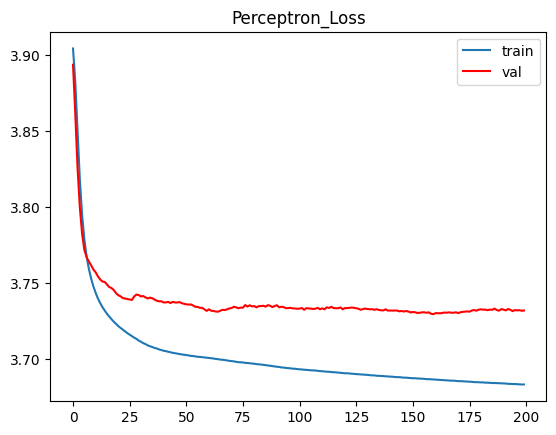

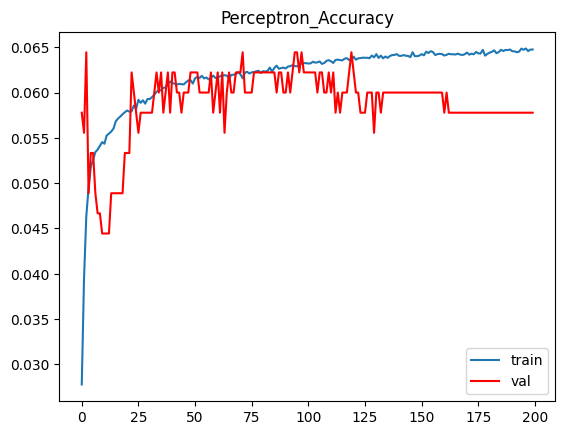

In [14]:
filename = './model/TwoLayerPerceptron.sav'
loaded_model = pickle.load(open(filename, 'rb'))

with open("./loss/ls_train_loss.txt", "r") as fp:
    ls_train_loss = json.load(fp)
with open("./loss/ls_val_loss.txt", "r") as fp:
    ls_val_loss =./loss/ json.load(fp)
with open("./loss/ls_train_acc.txt", "r") as fp:
    ls_train_acc = json.load(fp)
with open("./loss/ls_val_acc.txt", "r") as fp:
    ls_val_acc = json.load(fp)
    
# draw
plt.title('Perceptron_Loss')
plt.plot(range(n_epochs), ls_train_loss, label="train")
plt.plot(range(n_epochs), ls_val_loss, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/perceptron_loss.png')
plt.show()

plt.title('Perceptron_Accuracy')
plt.plot(range(n_epochs), ls_train_acc, label="train")
plt.plot(range(n_epochs), ls_val_acc, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/perceptron_acc.png')
plt.show() 

In [ ]:
trainx = preprocessing.scale(train_x)
pred_y = loaded_model.predict(trainx)
acc = np.mean(pred_y == train_y)
print('Train Accuracy : ', acc)
valx = preprocessing.scale(val_x)
pred_y = loaded_model.predict(valx)
acc = np.mean(pred_y == val_y)
print('val Accuracy : ', acc)
testx = preprocessing.scale(test_x)
pred_y = loaded_model.predict(testx)
acc = np.mean(pred_y == test_y)
print('Test Accuracy : ', acc)

### Compare with sklearn Perceptron

In [ ]:
clf = Perceptron(tol=1e-5, n_jobs = 40, early_stopping = True, warm_start = True, max_iter = 2000)
clf.fit(train_x, train_y)

print('訓練集: ', clf.score(train_x, train_y))
print('驗證集: ', clf.score(val_x, val_y))
print('測試集: ', clf.score(test_x, test_y))